# Pipeline for Aster Data Analysis using the ATeam Probe

Today we will extract ATP gradients from an aster dataset. Executing the next few cells will import all the relevant data.

## Imports

In [1]:
# Packages to locally download data into the notebook:
# import requests
# import zipfile
import glob

#### Numpy #####
import numpy as np

#### Matplotlib ####

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.animation as animation

#### Skimage ####

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import regionprops
import cv2

#for image registration
from skimage.registration import phase_cross_correlation
import os


#For movie Plotting
import plotting
import celluloid as cell

# For loading bars
from tqdm.notebook import tqdm as tqdm

## Import Images

Function for turning file paths into image arrays

In [2]:
def file_to_image(files):
    """
    Takes in a file list and converts to images.
    
    Parameters:
    files: list of file names that you want to read into images
    
    Returns:
    An array of np.int16 images
    """
    im_list = list()
    for file in files:
        im = skimage.io.imread(file)
        im_list.append(im.astype(np.int16))

    return np.array(im_list)

Specify the paths for data. EDIT THIS EACH TIME

In [3]:
##### Paths for image files #####

#Choose the experiment file name(located in folder 'Asters'):
folder_path = '../../data/aster/'

folder = '2022-06-28_NCD_ATeam_UMT/2022-06-28_NCD_ATeam_UMT_R4_1/'

file_path = folder_path + folder

# #Choose the position(s)/aster(s) of interest:
pos_list = ['Pos1']

#Choose the channels of interest (this is almost always going to be Cherry and iATP)
channel_list = ['GFP', 'CFP', 'Bright','Cherry']

#included frames
included_frames = '*2022*.tif'


##### Paths for background subtraction #####

#Choose the experiment file name(located in folder 'Asters'):
folder_path_bs = '../../data/aster/'

folder_bs = '2022-06-15_Ncd_ATeam_Victor+Cathy/2022-06-13_Ncd_ATeam_Victor+cathy_darkims/'

file_path_bs = folder_path_bs + folder_bs

### Creating image arrays

In [4]:
# Import images
for pos in pos_list:
    for channel in channel_list:

        #creates an empty list with the naming convention
        exec('im_files' + channel + pos + '= []')
        im_files = eval('im_files' + channel + pos)
        
        #appends all the file names
        im_files.append(
            np.sort(
                glob.glob(file_path + '/' + pos + '/' + channel + '/' +
                          included_frames)))

        #Reads the files as images
        exec('im_array' + channel + pos + ' = file_to_image(im_files[0])')
        print('im_array' + channel + pos)

im_arrayGFPPos1
im_arrayCFPPos1
im_arrayBrightPos1
im_arrayCherryPos1


### Reading bg images

In [5]:
# Camera dark images - for background subtraction

im_MT_dark = skimage.io.imread((np.sort(glob.glob(file_path_bs + '*C1*.tif')))[0]).astype(np.int16)
im_GFP_dark = skimage.io.imread((np.sort(glob.glob(file_path_bs + '*C2*.tif')))[0]).astype(np.int16)
im_CFP_dark = skimage.io.imread((np.sort(glob.glob(file_path_bs + '*C3*.tif')))[0]).astype(np.int16)
im_Cherry_dark = skimage.io.imread((np.sort(glob.glob(file_path_bs + '*C4*.tif')))[0]).astype(np.int16)

### Param calibration

In [6]:
#Length Calibration (microns to pixels)
um_per_pixel = 0.59

#Image dims
w_px, h_px = 1920, 1200  #pixels
w_um, h_um = w_px * um_per_pixel, h_px * um_per_pixel  # microns

#min area thresh (IN PIXELS)
area_thresh = 5000

#Fontsize
f_small, f_big = 13, 15

#timestamps (IN FRAMES)
total_frames = 200
T_min = 20
T_span = total_frames - T_min

#??
winsize = 100
thickness = 5
scale = 5

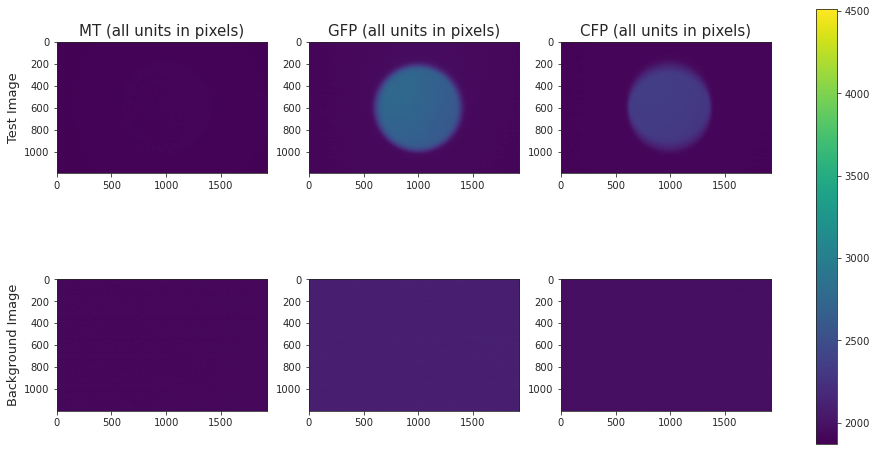

In [7]:
frame = 3
im_motor = im_arrayCherryPos1[frame]
im_CFP = im_arrayCFPPos1[frame]
im_GFP = im_arrayGFPPos1[frame]

#define colorbar max and min
colorbar_max = np.percentile(im_GFP, 100)
colorbar_min = np.percentile(im_CFP, 0)

#define plot
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
cmap = cm.get_cmap('viridis')
normalizer = Normalize(colorbar_min, colorbar_max)
cb_setting = cm.ScalarMappable(norm=normalizer, cmap = cmap)

#define each subplot
ax[0, 0].imshow(im_motor, cmap=cmap)
ax[0, 0].set_title(r'MT (all units in pixels)', fontsize=f_big)
ax[0, 0].set_ylabel(r'Test Image', fontsize=f_small)

ax[0, 1].imshow(im_GFP, cmap=cmap)
ax[0, 1].set_title(r'GFP (all units in pixels)', fontsize=f_big)

ax[0, 2].imshow(im_CFP, cmap=cmap)
ax[0, 2].set_title(r'CFP (all units in pixels)', fontsize=f_big)

#subplots: setting bg plots
ax[1, 0].imshow(im_Cherry_dark, cmap=cmap)
ax[1, 0].set_ylabel(r'Background Image', fontsize=f_small)

ax[1, 1].imshow(im_GFP_dark, cmap=cmap)

ax[1, 2].imshow(im_CFP_dark, cmap=cmap)

fig.colorbar(cb_setting, ax=ax.ravel().tolist())

### Subtract camera dark images

In [8]:
im_arrayCherryPos1_bs = im_arrayCherryPos1 - im_Cherry_dark
im_arrayGFPPos1_bs = im_arrayGFPPos1 - im_GFP_dark
im_arrayCFPPos1_bs = im_arrayCFPPos1 - im_CFP_dark

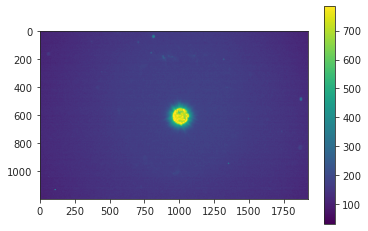

In [9]:
# test

plt.imshow(im_arrayCherryPos1_bs[60], 
           cmap = cmap, 
           vmin = np.percentile(im_arrayCherryPos1_bs[60], 0), 
           vmax = np.percentile(im_arrayCherryPos1_bs[60], 99.9))
plt.colorbar()

### Crop

Find the center for each image

### Center

In [11]:
c_ymin, c_ymax, c_xmin, c_xmax = 475, 735, 870, 1150
# define crop window
crop = np.s_[c_ymin:c_ymax, c_xmin:c_xmax]

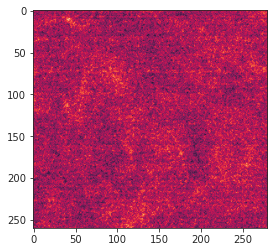

In [13]:
plt.imshow(im_arrayCherryPos1_bs[10][crop])

In [10]:
#init empty lists for center vals, radius, frame #
centers_tc = []
radii = []
frame_num = []
contours_plot = []

#for loop thru MT images
for i, im in enumerate(im_arrayCherryPos1_bs):
    #crop image for center identification
    image = im

    #perform otsu threshholding
    thresh = threshold_otsu(image)

    #create binary image
    binary = (image > thresh).astype(np.uint8)

    #create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)

    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area and 100000 >= max_area:
            max_area = area
            max_index = j

    if 100000 >= max_area >= area_thresh:
        cnt = contours[max_index]
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        centers_tc.append([x, y])
        radii.append(radius)
        frame_num.append(i)
        contours_plot.append(cnt)
    else:
        print("**CENTER NOT FOUND** Frame " + str(i))
        cnt = contours[max_index]
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        centers_tc.append([0, 0])
        radii.append(radius)
        frame_num.append(i)
        contours_plot.append(cnt)
        
centers_tc = np.array(centers_tc)
radii = np.array(radii)
frame_num = np.array(frame_num)

**CENTER NOT FOUND** Frame 0
**CENTER NOT FOUND** Frame 1
**CENTER NOT FOUND** Frame 2
**CENTER NOT FOUND** Frame 3
**CENTER NOT FOUND** Frame 4
**CENTER NOT FOUND** Frame 5
**CENTER NOT FOUND** Frame 6
**CENTER NOT FOUND** Frame 7
**CENTER NOT FOUND** Frame 8
**CENTER NOT FOUND** Frame 9
**CENTER NOT FOUND** Frame 10
**CENTER NOT FOUND** Frame 11
**CENTER NOT FOUND** Frame 12
**CENTER NOT FOUND** Frame 13
**CENTER NOT FOUND** Frame 14
**CENTER NOT FOUND** Frame 15
**CENTER NOT FOUND** Frame 16
**CENTER NOT FOUND** Frame 17
**CENTER NOT FOUND** Frame 18
**CENTER NOT FOUND** Frame 19
**CENTER NOT FOUND** Frame 20
**CENTER NOT FOUND** Frame 21
**CENTER NOT FOUND** Frame 22
**CENTER NOT FOUND** Frame 189
**CENTER NOT FOUND** Frame 190
**CENTER NOT FOUND** Frame 191
**CENTER NOT FOUND** Frame 192
**CENTER NOT FOUND** Frame 193
**CENTER NOT FOUND** Frame 194
**CENTER NOT FOUND** Frame 195
**CENTER NOT FOUND** Frame 196
**CENTER NOT FOUND** Frame 197
**CENTER NOT FOUND** Frame 198
**CENTER N

### Center (w/ Gaussian blur)

In [27]:
c_ymin, c_ymax, c_xmin, c_xmax = 100, 900, 700, 1500

In [28]:
im = im_arrayCherryPos1_bs[30]

dst = gaussian(im[crop], sigma=50)
thresh = np.percentile(dst, 99)
binary = (dst>thresh).astype(np.uint8)

#create a contour
contours, hierarchy = cv2.findContours(binary, 1, 2)

In [29]:
cnt = np.array(contours)
cnt = np.squeeze(cnt)

In [30]:
cnt[:,0] = cnt[:,0] + c_xmin
cnt[:,0]

array([ 992,  991,  988,  987,  985,  984,  983,  982,  981,  980,  979,
        977,  976,  969,  969,  967,  967,  965,  965,  964,  964,  963,
        963,  962,  962,  961,  961,  960,  960,  961,  961,  962,  962,
        963,  963,  964,  964,  965,  965,  966,  966,  967,  967,  969,
        969,  978,  979,  981,  982,  983,  984,  985,  986,  987,  988,
        989,  990,  991,  994,  995,  998,  999, 1013, 1014, 1018, 1019,
       1021, 1022, 1024, 1025, 1026, 1027, 1028, 1030, 1031, 1033, 1034,
       1040, 1040, 1043, 1043, 1044, 1044, 1045, 1045, 1046, 1046, 1047,
       1047, 1048, 1048, 1049, 1049, 1048, 1048, 1047, 1047, 1046, 1046,
       1045, 1045, 1044, 1044, 1043, 1043, 1041, 1041, 1036, 1036, 1035,
       1030, 1029, 1027, 1026, 1025, 1024, 1022, 1021, 1020, 1018, 1017,
       1015, 1014, 1012, 1011, 1008, 1007], dtype=int32)

In [31]:
#init empty lists for center vals, radius, frame #
centers_tc = []
radii = []
frame_num = []
contours_plot = []

#for loop thru MT images
for i, im in tqdm(enumerate(im_arrayCherryPos1_bs)):
    #crop image for center identification

    #gaussian blur
    dst = gaussian(im[crop], sigma=50)
    thresh = np.percentile(dst, 99)
    binary = (dst>thresh).astype(np.uint8)
    
    #create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)

    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j

    if max_area >= area_thresh:
        cnt = contours[max_index]
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        centers_tc.append([x + c_xmin, y + c_ymin])
        radii.append(radius)
        frame_num.append(i)
        
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)
        
    else:
        print("**CENTER NOT FOUND**")
        cnt = contours[max_index]
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        centers_tc.append([0, 0])
        radii.append(radius)
        frame_num.append(i)
        
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)
        
centers_tc = np.array(centers_tc)
radii = np.array(radii)
frame_num = np.array(frame_num)

0it [00:00, ?it/s]

**CENTER NOT FOUND**
**CENTER NOT FOUND**
**CENTER NOT FOUND**
**CENTER NOT FOUND**
**CENTER NOT FOUND**


Find what the center vcalues are for full sized image

In [32]:
centers = []
for center in centers_tc:
    center_x = int(center[0])
    center_y = int(center[1])
    centers.append([center_x, center_y])
centers = np.array(centers)

(400.0, 600.0)

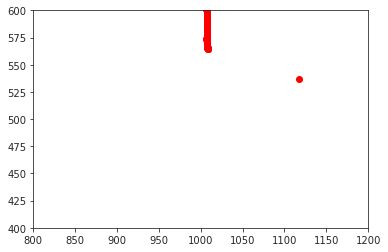

In [33]:
#TEST: plotting all centers

plt.figure()

for i in range(np.shape(centers)[0]):
    plt.scatter(centers[i, 0], centers[i, 1], color='r')

plt.xlim(800, 1200)
plt.ylim(400, 600)

## Making video

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

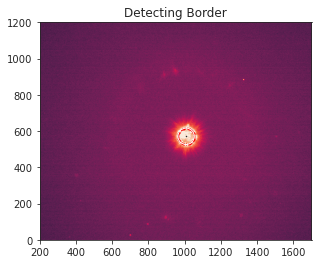

In [34]:
#TEST: checking ALL FRAMES centers (only run once please)
ims = []
cmap = cm.get_cmap('viridis')
normalizer = Normalize(colorbar_min, colorbar_max)
cb_setting = cm.ScalarMappable(norm=normalizer)
fig, ax = plt.subplots()

ax.set_xlim([200,1700])
ax.set_ylim([0,1200])
ax.set_title("Detecting Border")

camera = cell.Camera(fig)

for i in tqdm(range(total_frames)):
    im_temp = im_arrayCherryPos1_bs[i]
    im = ax.imshow(im_temp,
          vmin=np.percentile(im_temp, 0),
          vmax=np.percentile(im_temp, 99.9),
          animated=True,
          zorder = 0)
    
    ax.scatter(contours_plot[i][:, 0],
               contours_plot[i][:, 1],
               color='r',
               s=0.2)
    ax.scatter(centers_tc[i, 0], centers_tc[i, 1], color='black', s = 0.2)

    circle1 = plt.Circle((centers[i, 0], centers[i, 1]),
                         radii[i],
                         fill=False,
                         color='w')
    ax.add_patch(circle1)
    camera.snap()
    
animation = camera.animate()
tqdm(animation.save("movie.mp4"))

## Register

Register images

In [37]:
#Empty list to record how much CFP (probe) channel is shifted w.r.t. YFP (ATP is bound) channel
shifts = []

for i in range(total_frames):
    shift, error, _ = phase_cross_correlation(
        im_arrayGFPPos1_bs[i][tight_crop], im_arrayCFPPos1_bs[i][tight_crop])
    shifts.append(shift)

shifts = np.array(shifts)

## Analyzing Images

In [38]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
        
    mask = dist_from_center <= radius
    return mask

In [41]:
#cropped aster images
im_arrayGFPPos1_plot = []
im_arrayCFPPos1_plot = []
im_arrayCherryPos1_plot = []
ratios_plot = []

#Traces for asters
GFP_trace_pts = []
CFP_trace_pts = []
motor_trace_pts = []
ratios_trace_pts = []

for j in range(T_span):

    i = j + T_min
    #Set the window parameters
    i_min = int(centers[i][0] - winsize)
    i_max = int(centers[i][0] + winsize)
    j_min = int(centers[i][1] - winsize)
    j_max = int(centers[i][1] + winsize)

    #demi-variable for shift
    shift_j = int(shifts[i][0])
    shift_i = int(shifts[i][1])

    #set YFP and CFP windows
    winGFP = np.s_[j_min:j_max, i_min:i_max]
    winCFP = np.s_[(j_min - shift_j):(j_max - shift_j),
                   (i_min - shift_i):(i_max - shift_i)]

    #Append the plotting images
    [h, w] = np.shape(im_arrayGFPPos1_bs[i])
    mask = 1 * create_circular_mask(h,w,centers[i],thickness) 
    
    im_arrayGFPPos1_plot.append(im_arrayGFPPos1_bs[i][winGFP])
    im_arrayCFPPos1_plot.append(im_arrayCFPPos1_bs[i][winCFP])
    im_arrayCherryPos1_plot.append(im_arrayCherryPos1_bs[i][winCFP])
    #for now MT same as CFP shifts, running the shift cell seems closest to CFP

    ratio = im_arrayGFPPos1_bs[i][winGFP] / im_arrayCFPPos1_bs[i][winCFP]
    ratios_plot.append(ratio)

    #Define a narrow srip to take trace values
    GFP_trace = im_arrayGFPPos1_plot[j][(winsize - thickness):(winsize +
                                                               thickness), :]
    CFP_trace = im_arrayCFPPos1_plot[j][(winsize - thickness):(winsize +
                                                               thickness), :]
    motor_trace = im_arrayCherryPos1_plot[j][(winsize - thickness):(winsize +
                                                                 thickness), :]
    ratios_trace = ratios_plot[j][(winsize - thickness):(winsize +
                                                         thickness), :]

    #average the strips
    GFP_trace_pts.append(np.average(GFP_trace, axis=0))
    CFP_trace_pts.append(np.average(CFP_trace, axis=0))
    motor_trace_pts.append(np.average(motor_trace, axis=0))
    ratios_trace_pts.append(np.average(ratios_trace, axis=0))

im_arrayGFPPos1_plot = np.array(im_arrayGFPPos1_plot)
im_arrayCFPPos1_plot = np.array(im_arrayCFPPos1_plot)
im_arrayCherryPos1_plot = np.array(im_arrayCherryPos1_plot)
ratios_plot = np.array(ratios_plot)

GFP_trace_pts = np.array(GFP_trace_pts)
CFP_trace_pts = np.array(CFP_trace_pts)
motor_trace_pts = np.array(motor_trace_pts)
ratios_trace_pts = np.array(ratios_trace_pts)

pos_xaxis = np.linspace(-winsize, winsize, 2 * winsize)
actual_frame = np.arange(T_min * scale, (T_span + T_min) * scale, scale) #not sure about last param

### Plotting analysis

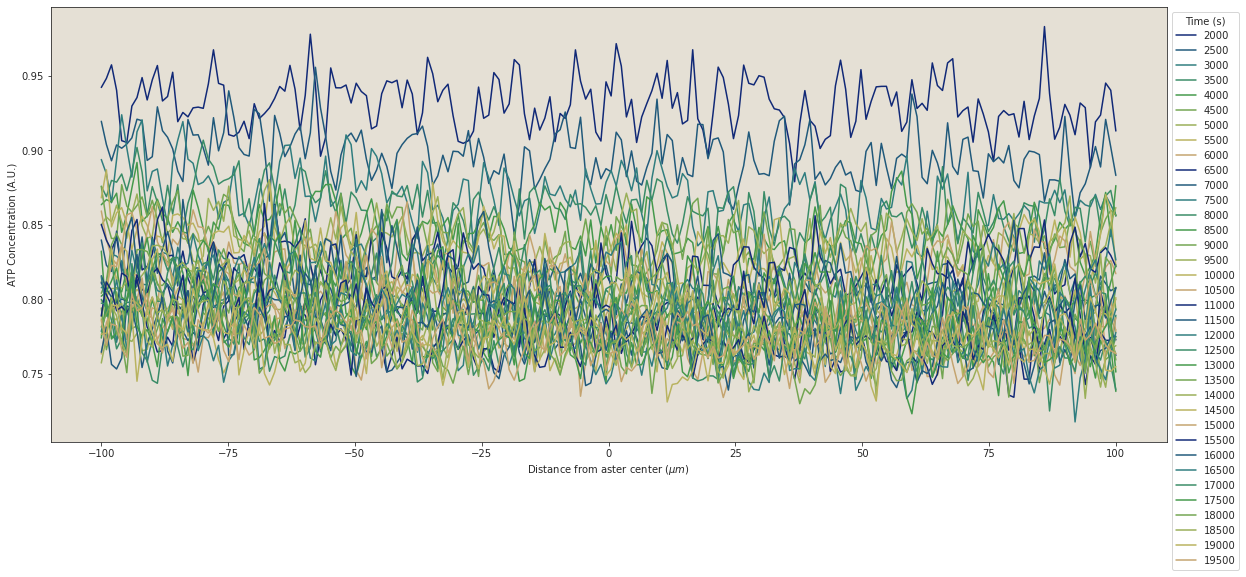

In [59]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.gca().set_prop_cycle(
    plt.cycler(
        'color',
        plt.cm.gist_earth(np.linspace(0.1, 0.80, int(len(ratios_trace_pts)/20)))))

for i, trace in enumerate(ratios_trace_pts):
    if i%5 == 0:
        plt.plot(pos_xaxis, trace, label=str(actual_frame[i] * 20))
    #     cmap = cm.get_cmap('')
    #     normalizer = Normalize(colorbar_min, colorbar_max)
    #     cb_setting = cm.ScalarMappable(norm=normalizer)
    #     plt.colorbar()
        plt.legend(bbox_to_anchor=(1, 1), loc="upper left", title='Time (s)')

plt.xlabel('Distance from aster center ($\mu m$)')
plt.ylabel('ATP Concentration (A.U.)')
ax.set_facecolor('#E5E0D5')

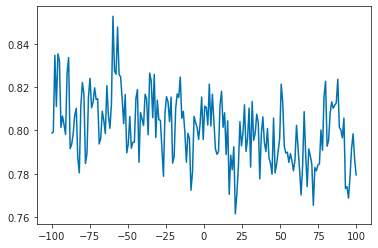

In [61]:
plt.plot(pos_xaxis, ratios_trace_pts[80])

NameError: name 'im_arrayBrightPos0_bs' is not defined

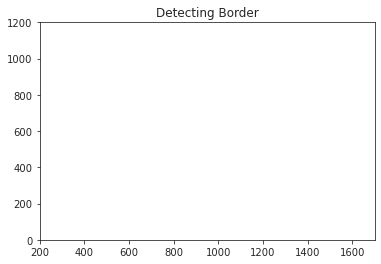

In [43]:


#TEST: checking ALL FRAMES centers (only run once please)
ims = []
cmap = cm.get_cmap('viridis')
normalizer = Normalize(colorbar_min, colorbar_max)
cb_setting = cm.ScalarMappable(norm=normalizer)
fig, ax = plt.subplots()

ax.set_xlim([200,1700])
ax.set_ylim([0,1200])
ax.set_title("Detecting Border")

camera = cell.Camera(fig)

for i in range(total_frames):
    im_temp = im_arrayBrightPos0_bs[i]
    im = ax.imshow(im_temp,
          vmin=np.percentile(im_temp, 0),
          vmax=np.percentile(im_temp, 100),
          animated=True,
          zorder = 0)
    
    ax.scatter(contours_plot[i][:, 0, 0],
               contours_plot[i][:, 0, 1],
               color='r',
               s=0.3)
    ax.scatter(centers_tc[i, 0], centers_tc[i, 1], color='black')

    circle1 = plt.Circle((centers[i, 0], centers[i, 1]),
                         radii[i],
                         fill=False,
                         color='w')
    ax.add_patch(circle1)
    camera.snap()
    
animation = camera.animate()
animation.save("movie.mp4")


In [ ]:
from PIL import Image, ImageDraw
import io

In [ ]:
images = []
   
for i in range(0, 50000, 1000):
    fig = plt.figure()
    plt.imshow(ths_big[:,:,i], vmin = 0, vmax = 1, cmap = 'Greys_r' ,alpha=1)
    plt.imshow(zs_big[:,:,i], vmin = 0, vmax = 1, cmap = 'Blues', alpha=0.5)
    plt.imshow(exclusion, vmin = 0, vmax = 1, cmap = 'Greys')
   
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    im = Image.open(img_buf)
    images.append(im)
    plt.close(fig)
    
images[0].save('LarsenC.gif', save_all=True, append_images=images[1:], optimize=False, duration=140, loop=0)